In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import IPython.display as ipd

In [2]:
frequency_sampling, audio_signal = wavfile.read("./vad_data/1447-130551-0017.wav")
print('\nSignal shape:', audio_signal.shape)
print('Signal Datatype:', audio_signal.dtype)
print('Signal duration:', round(audio_signal.shape[0] / 
float(frequency_sampling), 2), 'seconds')


Signal shape: (232160,)
Signal Datatype: int16
Signal duration: 14.51 seconds


In [3]:
frequency_sampling

16000

In [6]:
audio_signal = audio_signal / np.power(2, 15)
audio_signal = audio_signal [:100]
time_axis = 1000 * np.arange(0, len(audio_signal), 1) / float(frequency_sampling)

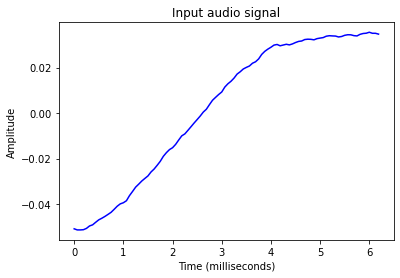

In [7]:
plt.plot(time_axis, audio_signal, color='blue')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.title('Input audio signal')
plt.show()

In [4]:
audio_data = '././vad_data//1034-121119-0051.wav'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [10]:
1/sr * len(x)

14.98

In [3]:
start = 8.25
end = 8.26
seg_star = int(np.floor(start * sr))
seg_end = int(np.floor(end * sr))
print(seg_star, seg_end)

NameError: name 'sr' is not defined

In [6]:
ipd.Audio(audio_data)

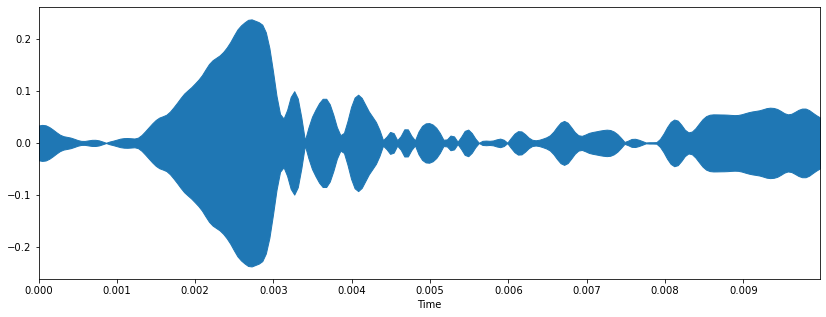

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x[seg_star:seg_end], sr=sr)

In [4]:
audio_data = './vad_data/1034-121119-0051.wav'
x , sr = librosa.load(audio_data)
start = 10
end = 11
seg_star = int(np.floor(start * sr))
seg_end = int(np.floor(end * sr))
ipd.Audio(data=x[seg_star:seg_end], rate=sr)

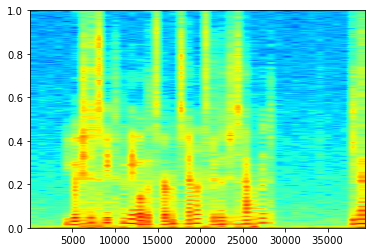

In [19]:
y, sr = librosa.load(audio_data, mono=True, duration=5, sr=16000)
plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='jet',
             sides='default', mode='default', scale='dB');

In [20]:
mfcc = librosa.feature.mfcc(x[seg_star:seg_end], sr, n_mfcc=13, n_fft=512 ,hop_length=128)
librosa.feature.delta(mfcc)

array([[ 0.8746908 ,  0.8746908 ,  0.8746908 , ..., -8.016322  ,
        -8.016322  , -8.016322  ],
       [-0.41103044, -0.41103044, -0.41103044, ..., -1.3777509 ,
        -1.3777509 , -1.3777509 ],
       [-3.3807411 , -3.3807411 , -3.3807411 , ...,  4.0468273 ,
         4.0468273 ,  4.0468273 ],
       ...,
       [-0.2699696 , -0.2699696 , -0.2699696 , ...,  0.7222117 ,
         0.7222117 ,  0.7222117 ],
       [-0.4693213 , -0.4693213 , -0.4693213 , ...,  2.9502723 ,
         2.9502723 ,  2.9502723 ],
       [ 0.96404135,  0.96404135,  0.96404135, ...,  0.85506886,
         0.85506886,  0.85506886]], dtype=float32)

In [5]:
import  pandas as pd
df = pd.read_csv('output.csv')
df['duration'].describe()

count    32560.000000
mean         0.292381
std          0.175828
min          0.010000
25%          0.150000
50%          0.250000
75%          0.400000
max          1.360000
Name: duration, dtype: float64

In [2]:
def extract_features(signal, sr=16000, n_mfcc=5, size=512, step=16, n_mels=40):
    mfcc = librosa.feature.mfcc(signal, sr=sr, n_mfcc=n_mfcc, n_fft=size, hop_length=step)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)

    mel_spectogram = librosa.feature.melspectrogram(signal, sr=sr, n_mels=n_mels, n_fft=size, hop_length=step)
    rmse = librosa.feature.rms(S=mel_spectogram, frame_length=n_mels * 2 - 1, hop_length=step)

    mfcc, mfcc_delta, mfcc_delta_2, rmse = np.asarray(mfcc), np.asarray(mfcc_delta), np.asarray(mfcc_delta_2), np.asarray(rmse)
    # print(mfcc.shape, mfcc_delta.shape, mfcc_delta_2.shape, rmse.shape)
    features = np.concatenate((mfcc, mfcc_delta, mfcc_delta_2, rmse), axis=0)
    return features.transpose()

nbseg = (seg_end - seg_star)//1024
print(nbseg)
data = []
start = seg_star
for seg in range(nbseg):
    data.append(extract_features(x[start:start+1024]))
    start += 1024

NameError: name 'seg_end' is not defined

In [12]:
import tensorflow as tf
import numpy as np
import time
model = tf.keras.models.load_model('models/cnn.h5')

In [27]:
%%time
data = np.random.rand(1, 65, 16, 1)
# s = time.time()
a = model.predict(data)
# print(time.time()-s)
a[0,0] + a[0, 1]

CPU times: user 45.2 ms, sys: 7.99 ms, total: 53.2 ms
Wall time: 48.7 ms


1.0

# Test with real-time data

In [5]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from noisereduce.noisereducev1 import reduce_noise
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
import IPython
import os
import pyaudio
from gendata import extract_features
CHUNKSIZE = 1024 # fixed chunk size
RATE = 16000

# initialize portaudio
p = pyaudio.PyAudio()

In [32]:
%%time
extract_features(np.random.rand(1024,))

CPU times: user 158 ms, sys: 8.44 ms, total: 167 ms
Wall time: 37.3 ms


array([[-6.44429194e+01, -1.77762955e+01, -1.52598032e+00, ...,
         3.13949732e-01,  3.77413575e-01,  3.01724734e-01],
       [-5.85469789e+01, -1.11064377e+01,  1.99753874e+00, ...,
         3.13949732e-01,  3.77413575e-01,  3.00421798e-01],
       [-5.43510998e+01, -7.61015085e+00,  1.19364147e+00, ...,
         3.13949732e-01,  3.77413575e-01,  2.97088144e-01],
       ...,
       [-5.33686142e+01, -1.63990484e+01,  2.94288999e-01, ...,
         1.45333465e-01, -7.08600855e-02,  3.10617747e-01],
       [-5.53458513e+01, -1.79867083e+01, -4.21627617e-02, ...,
         1.45333465e-01, -7.08600855e-02,  3.06435022e-01],
       [-5.66782489e+01, -1.93290327e+01, -7.14296762e-01, ...,
         1.45333465e-01, -7.08600855e-02,  3.05012249e-01]])

In [6]:
#Some Utils
lb = LabelEncoder()
lb.fit_transform(['Calling', 'Clapping', 'Falling', 'Sweeping', 'WashingHand', 'WatchingTV','enteringExiting','other'])
# Plot audio with zoomed in y axis
def plotAudio(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10))
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    ax.margins(2, -0.1)
    plt.show()

# Plot audio
def plotAudio2(output):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    plt.plot(output, color='blue')
    ax.set_xlim((0, len(output)))
    plt.show()

def minMaxNormalize(arr):
    mn = np.min(arr)
    mx = np.max(arr)
    return (arr-mn)/(mx-mn)

def predictSound(X):
    features = extract_features(X)
    result = model.predict(np.array([features]))
#     predictions = [np.argmax(y) for y in result]
#     print(predictions)
    return result[0][1]#np.argmax(result)

In [14]:
stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)

while(True):
    # Read chunk and load it into numpy array.
    data = stream.read(CHUNKSIZE, exception_on_overflow = False)
    current_window = np.frombuffer(data, dtype=np.float32)
    
    #Reduce noise real-time
#     current_window = reduce_noise(audio_clip=current_window, noise_clip=noise_sample, verbose=False)
    
    print(predictSound(current_window))

# close stream
stream.stop_stream()
stream.close()
p.terminate()

1.1598395e-12
6.3983875e-12
1.0258013e-06
1.9395058e-10
9.4783195e-09
5.975417e-11
6.9483833e-12
1.1280661e-10
2.2460051e-06
1.4464199e-08
2.0704147e-10
5.0451412e-08
8.751931e-12
4.511071e-08
6.2173994e-12
6.2062304e-12
1.2054645e-12
6.8666806e-05
9.371982e-11
5.6816503e-09
1.2084546e-08
5.0583054e-10
2.4325724e-09
1.4703446e-06
1.2593893e-11
4.3893085e-09
1.6331e-07
5.679337e-09
9.779982e-11
5.148403e-10
1.11044055e-05
2.468165e-13
1.4664198e-09
2.6628094e-10
5.7985233e-15
3.318639e-14
1.815275e-10
1.9373224e-10
9.571732e-10
6.4172296e-16
2.7839393e-12
1.3082572e-09
4.4617175e-11
3.439104e-12
8.3114836e-13
5.1460006e-11
2.8091938e-06


KeyboardInterrupt: 

In [13]:
np.random.rand()

0.892241947356624

In [7]:
from jupyterplot import ProgressPlot
import numpy as np

# pp = ProgressPlot()
pp = ProgressPlot(plot_names=["Silero VAD"],line_names=["speech probabilities"], x_label="audio chunks")
for i in range(1000):
    x = 0 if np.random.rand() < 0.5 else 1
    pp.update(x)
pp.finalize()

In [23]:
np.sin(1 / 100)

0.009999833334166664

In [8]:
from jupyterplot import ProgressPlot
import threading

continue_recording = True

def stop():
    input("Press Enter to stop the recording:")
    global continue_recording
    continue_recording = False

def start_recording():
    
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)

    data = []
    voiced_confidences = []
    
    global continue_recording
    continue_recording = True
    
    pp = ProgressPlot(plot_names=["Voice Activity Detection"],line_names=["speech probabilities"], x_label="audio chunks")
    
    stop_listener = threading.Thread(target=stop)
    stop_listener.start()

    while continue_recording:
    
        data = stream.read(CHUNKSIZE, exception_on_overflow = False)
        current_window = np.frombuffer(data, dtype=np.float32)    
        # get the confidences and add them to the list to plot them later
        new_confidence = predictSound(current_window)
#         print(new_confidence)
        pp.update(float(new_confidence))


    pp.finalize()

In [35]:
start_recording()

Press Enter to stop the recording:
